# Quantum Analytic Descent

#### Einleitung
Die Idee hinter Quantum Analytic Descent ist eine Kostenfunktion mit Hilfe einer Kombination aus Quantencomputern und klassischen Minimierungen zu minimieren. Dabei wird wie folgt vorgegangen: Mit einem Quantencomputer wird die Kostenfunktion an einem Referenzpunkt so wie an mehreren Punkten um diesen Punkt genau auszuwerten. Die erhaltenen werte werden genutzt um ein klassisches Modell zu erzeugen, dass die Kostenfunktion in der Umgebung des Referenzpunktes näherungsweise abbildet. In diesem klassischen Modell wird mit klassischer Optimierung das Minimum bestimmt. Dieses Minumum wird als neuer Referenzpunkt verwendet und das Vorgehen so lange wiederholt, bis das Minimum erreicht ist.

#### Code
Es werden dir notwendigen Packete importiert.

In [1]:
#Importiere die notwendigen Packages
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
import copy

Es wird ein seed gesetzt, um die Pseudozufallsprozesse reproduzierbar zu machen.

In [2]:
warnings.filterwarnings("ignore")

np.random.seed(0)

Definiere ein Device mit dem Namen "dev" und zwei Qbits.
Definiere eine Quantenfunktion mit dem Argument "parameters". Auf beiden wires findet eine Rotation um die X-Achse um den Winkel parameters[0] bzw. parameters[1] statt. Die Ausgabe der Funktion sind die mit einem Pauli Z Gate ausgewerteten Wires. Die Funktion wird mit @qml.qnode() in eine QNode umgewandelt, die auf dem Device dev läuft.

In [3]:
# Create a device with 2 qubits.
dev = qml.device("default.qubit", wires=2)

# Define the variational form V and observable M and combine them into a QNode.
@qml.qnode(dev, diff_method="parameter-shift", max_diff=2)
def circuit(parameters):
    qml.RX(parameters[0], wires=0)
    qml.RX(parameters[1], wires=1)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

Um das Verhalten der Funktion zu überprüfen wird diese ausgewertet, wobei jeweils einer der beiden Parameter konstant gehalten wird (3.3 bzw. 0.5). Das Ergebnis wird für beide Parameter geplottet mit dem varierten Parameter theta auf der X-Achse und der Energie (Ausgabe der Funktion circuit) auf der Y-Achse.

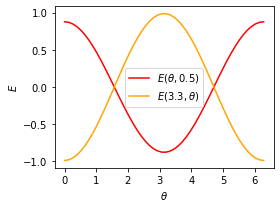

In [4]:
# Create 1D sweeps through parameter space with the other parameter fixed.
num_samples = 50

# Fix a parameter position.
parameters = np.array([3.3, 0.5], requires_grad=True)

theta_func = np.linspace(0, 2 * np.pi, num_samples)
C1 = [circuit(np.array([theta, parameters[1]])) for theta in theta_func]
C2 = [circuit(np.array([parameters[0], theta])) for theta in theta_func]

# Show the sweeps.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(theta_func, C1, label="$E(\\theta, 0.5)$", color="r")
ax.plot(theta_func, C2, label="$E(3.3, \\theta)$", color="orange")
ax.set_xlabel("$\\theta$")
ax.set_ylabel("$E$")
ax.legend()
plt.tight_layout()

Zusätzlich zur Auswertung bei konstanten Parametern, wird die Funktion im gesamten Parameterraum ausgewertet, indem die Werte auf Gitterpunkten berechnet werden. Zur besseren Ansicht wird ein Kreis mit Radius 2 um den Punkt (2$\pi$,0) nicht ausgewertet. Das Ergebnis wird in einem Surfice-Plot zusammen mit den Kurven aus dem vorheringen Plot dargestellt.

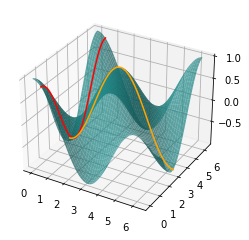

In [5]:
# Create a 2D grid and evaluate the energy on the grid points.
# We cut out a part of the landscape to increase clarity.
X, Y = np.meshgrid(theta_func, theta_func)
Z = np.zeros_like(X)
for i, t1 in enumerate(theta_func):
    for j, t2 in enumerate(theta_func):
        # Cut out the viewer-facing corner
        if (2 * np.pi - t2) ** 2 + t1 ** 2 > 4:
            Z[i, j] = circuit([t1, t2])
        else:
            X[i, j] = Y[i, j] = Z[i, j] = np.nan

# Show the energy landscape on the grid.
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(4, 4))
surf = ax.plot_surface(X, Y, Z, label="$E(\\theta_1, \\theta_2)$", alpha=0.7, color="#209494")
line1 = ax.plot(
    [parameters[1]] * num_samples,
    theta_func,
    C1,
    label="$E(\\theta_1, \\theta_2^{(0)})$",
    color="r",
    zorder=100,
)
line2 = ax.plot(
    theta_func,
    [parameters[0]] * num_samples,
    C2,
    label="$E(\\theta_1^{(0)}, \\theta_2)$",
    color="orange",
    zorder=100,
)

#### Mathematik für das Model
Der verwendete Quanten-Cuircit hängt von den n=2 Parametern $\underline{\theta}=(\theta_1,\theta_2,...,\theta_n)$ ab und lässt sich allgemein als ein Produkt von n Pauli-Gattern ausdrücken:
<img src="https://latex.codecogs.com/svg.image?\Phi(\underline{\theta}):=\Phi_n(\theta_n)...\Phi_2(\theta_2)\Phi_1(\theta_1)" title="https://latex.codecogs.com/svg.image?\Phi(\underline{\theta}):=\Phi_n(\theta_n)...\Phi_2(\theta_2)\Phi_1(\theta_1)" />  
Ziel ist die Näherung um einen Punkt $\theta_0$. Für jedes einzelne Gatter gilt dann
<img src="https://latex.codecogs.com/svg.image?\Phi_k(\theta):=U_k(\theta)U_k(\theta_0)\rho&space;U_k^\dag(\theta_0)U_k(\theta)" title="https://latex.codecogs.com/svg.image?\Phi_k(\theta):=U_k(\theta)U_k(\theta_0)\rho U_k^\dag(\theta_0)U_k(\theta)" />  
Wobei $U_k(\theta_k):=\exp(-i\theta_kP_k/2)$
Daraus folgt
<img src="https://latex.codecogs.com/svg.image?\Phi_k(\theta)=a(\theta)\Phi_{ak}&plus;b(\theta)\Phi_{bk}&plus;c(\theta)\Phi_{ck}" title="https://latex.codecogs.com/svg.image?\Phi_k(\theta)=a(\theta)\Phi_{ak}+b(\theta)\Phi_{bk}+c(\theta)\Phi_{ck}" />  
mit
<img src="https://latex.codecogs.com/svg.image?\begin{align*}a(\theta)&:=(1&plus;\cos(\theta))/2&space;\\b(\theta)&:=\sin(\theta)/2&space;\\c(\theta)&:=(1-\cos(\theta))/2&space;\\\Phi_{ak}&:=\Phi_k(0)&space;\\\Phi_{bk}&:=\Phi_k(\pi/2)-\Phi_k(-\pi/2)&space;\\\Phi_{ck}&:=\Phi_k(\pi)\end{align*}" title="https://latex.codecogs.com/svg.image?\begin{align*}a(\theta)&:=(1+\cos(\theta))/2 \\b(\theta)&:=\sin(\theta)/2 \\c(\theta)&:=(1-\cos(\theta))/2 \\\Phi_{ak}&:=\Phi_k(0) \\\Phi_{bk}&:=\Phi_k(\pi/2)-\Phi_k(-\pi/2) \\\Phi_{ck}&:=\Phi_k(\pi)\end{align*}" />  
Durch Einsetzen in die Gleichung für $\Phi(\underline{\theta})$ erhält man
<img src="https://latex.codecogs.com/svg.image?\Phi(\underline{\theta})=\prod\limits_{k=1}^n\left[&space;\frac{1&plus;\cos(\theta_k)}{2}\Phi_{ak}&plus;\frac{\sin(\theta_k)}{2}\Phi_{bk}&plus;\frac{1-\cos(\theta_k)}{2}\Phi_{ck}\right]" title="\Phi(\underline{\theta})=\prod\limits_{k=1}^n\left[ \frac{1+\cos(\theta_k)}{2}\Phi_{ak}+\frac{\sin(\theta_k)}{2}\Phi_{bk}+\frac{1-\cos(\theta_k)}{2}\Phi_{ck}\right]" />  
und näherungsweise
<img src="https://latex.codecogs.com/svg.image?\Phi(\underline{\theta})\approx&space;A(\underline{\theta})\Phi^{(A)}&plus;\sum\limits_{k=1}^n\left[B_k(\underline{\theta})\Phi_k^{(B)}&plus;C_k(\underline\theta)\Phi_k^{(C)}\right]&plus;\sum\limits_{k=1}^n\sum\limits_{l=k&plus;1}^n\left[D_{kl}(\underline\theta)\Phi_{kl}^{(D)}\right]" title="\Phi(\underline{\theta})\approx A(\underline{\theta})\Phi^{(A)}+\sum\limits_{k=1}^n\left[B_k(\underline{\theta})\Phi_k^{(B)}+C_k(\underline\theta)\Phi_k^{(C)}\right]+\sum\limits_{k=1}^n\sum\limits_{l=k+1}^n\left[D_{kl}(\underline\theta)\Phi_{kl}^{(D)}\right]" />  
bzw.
<img src="https://latex.codecogs.com/svg.image?E(\underline{\theta})\approx&space;A(\underline{\theta})E^{(A)}&plus;\sum\limits_{k=1}^n\left[B_k(\underline{\theta})E_k^{(B)}&plus;C_k(\underline\theta)E_k^{(C)}\right]&plus;\sum\limits_{k=1}^n\sum\limits_{l=k&plus;1}^n\left[D_{kl}(\underline\theta)E_{kl}^{(D)}\right]" title="E(\underline{\theta})\approx A(\underline{\theta})E^{(A)}+\sum\limits_{k=1}^n\left[B_k(\underline{\theta})E_k^{(B)}+C_k(\underline\theta)E_k^{(C)}\right]+\sum\limits_{k=1}^n\sum\limits_{l=k+1}^n\left[D_{kl}(\underline\theta)E_{kl}^{(D)}\right]" />  
mit
<img src="https://latex.codecogs.com/svg.image?\begin{align*}E^{(A)}&=E(0)\\E_k^{(B)}&=E(\frac{1}{2}\pi\underline&space;v_k)-E(-\frac{1}{2}\pi\underline&space;v_k)\\E_k^{(C)}&=E(\pi\underline&space;v_k)\\E_{kl}^{(D)}&=E(\frac{1}{2}\pi\underline&space;v_k&plus;\frac{1}{2}\pi\underline&space;v_l)&plus;E(-\frac{1}{2}\pi\underline&space;v_k-\frac{1}{2}\pi\underline&space;v_l)-E(-\frac{1}{2}\pi\underline&space;v_k&plus;\frac{1}{2}\pi\underline&space;v_l))-E(\frac{1}{2}\pi\underline&space;v_k-\frac{1}{2}\pi\underline&space;v_l)\end{align*}" title="\begin{align*}E^{(A)}&=E(0)\\E_k^{(B)}&=E(\frac{1}{2}\pi\underline v_k)-E(-\frac{1}{2}\pi\underline v_k)\\E_k^{(C)}&=E(\pi\underline v_k)\\E_{kl}^{(D)}&=E(\frac{1}{2}\pi\underline v_k+\frac{1}{2}\pi\underline v_l)+E(-\frac{1}{2}\pi\underline v_k-\frac{1}{2}\pi\underline v_l)-E(-\frac{1}{2}\pi\underline v_k+\frac{1}{2}\pi\underline v_l))-E(\frac{1}{2}\pi\underline v_k-\frac{1}{2}\pi\underline v_l)\end{align*}" />  
wobei $\underline v_k$ der Standard Basisvektor ist.  
  
Zur Bestimmung der Koeffizienten werden sowohl erste als auch zweite Ableitungen benötigt. Die ersten Ableitungen können direkt mit der Pennylane Funktion grad() bestimmt werden. Um die Hesse-Matrix (also die zweiten Ableitungen) zu bestimmen, wird die Jakobi-Matrix des Gradienten berechnet.

### Code
Definiere eine Funktion, die als Input eine Funktion und deren Parameter nimmt und die Koeffizienten für die Näherung der Funktion für das klassische Model bei diesen Parametern berechnet.

In [6]:
def get_model_data(fun, params):
    """Computes the coefficients for the classical model, E^(A), E^(B), E^(C), and E^(D)."""
    num_params = len(params)

    # E_A contains the energy at the reference point
    E_A = fun(params)

    # E_B contains the gradient.
    E_B = qml.grad(fun)(params)

    hessian = qml.jacobian(qml.grad(fun))(params)

    # E_C contains the slightly adapted diagonal of the Hessian.
    E_C = np.diag(hessian) + E_A / 2

    # E_D contains the off-diagonal parts of the Hessian.
    # We store each pair (k, l) only once, namely the upper triangle.
    E_D = np.triu(hessian, 1)

    return E_A, E_B, E_C, E_D

Nutze die zuvor definierten Funktionen, um die Koeffizienten für das klassische Model für zwei zufällige Parameter aus dem Intervall [0,2$\pi$] zu berechnen.

In [7]:
parameters = np.random.random(2, requires_grad=True) * 2 * np.pi
print(f"Random parameters (params): {parameters}")
coeffs = get_model_data(circuit, parameters)
print(
    f"Coefficients at params:",
    f" E_A = {coeffs[0]}",
    f" E_B = {coeffs[1]}",
    f" E_C = {coeffs[2]}",
    f" E_D = {coeffs[3]}",
    sep="\n",
)

Random parameters (params): [3.44829694 4.49366732]
Coefficients at params:
 E_A = 0.20685619228992974
 E_B = [-0.06551083 -0.9306212 ]
 E_C = [-0.1034281 -0.1034281]
 E_D = [[0.         0.29472535]
 [0.         0.        ]]


Random parameters (params): $\begin{pmatrix} 3.44829694 \\ 4.49366732 \end{pmatrix}$  
Coefficients at params:  
$E_A=0.20685619228992974$  
$E_B=\begin{pmatrix} -0.06551083 \\ -0.9306212 \end{pmatrix}$  
$E_C=\begin{pmatrix} -0.1034281 \\ -0.1034281 \end{pmatrix}$  
$E_D=\begin{pmatrix} 0. & 0.29472535 \\ 0. & 0. \end{pmatrix}$

Definiere die Kostenfunktion im klassischen Model für die Parameter und zugehörigen Koeffizienten.

In [8]:
def model_cost(params, E_A, E_B, E_C, E_D):
    """Compute the model cost for relative parameters and given model data."""
    A = np.prod(np.cos(0.5 * params) ** 2)

    # For the other terms we only compute the prefactor relative to A
    B_over_A = 2 * np.tan(0.5 * params)
    C_over_A = B_over_A ** 2 / 2
    D_over_A = np.outer(B_over_A, B_over_A)

    all_terms_over_A = [
        E_A,
        np.dot(E_B, B_over_A),
        np.dot(E_C, C_over_A),
        np.dot(B_over_A, E_D @ B_over_A),
    ]

    cost = A * np.sum(all_terms_over_A)

    return cost

Vergleiche die Quantenfunktion und die Modelfunktion an den Parametern, um zu überprüfen, dass die Modelfuntion an diese Stelle exakt ist.

In [9]:
# Compute the circuit at parameters (This value is also stored in E_A=coeffs[0])
E_original = circuit(parameters)
# Compute the model at parameters by plugging in relative parameters 0.
E_model = model_cost(np.zeros_like(parameters), *coeffs)
print(
    f"The cost function at parameters:",
    f"  Model:    {E_model}",
    f"  Original: {E_original}",
    sep="\n",
)
# Check that coeffs[0] indeed is the original energy and that the model is correct at 0.
print(f"E_A and E_original are the same: {coeffs[0]==E_original}")
print(f"E_model and E_original are the same: {E_model==E_original}")

The cost function at parameters:
  Model:    0.20685619228992974
  Original: 0.20685619228992974
E_A and E_original are the same: True
E_model and E_original are the same: True


Vergleiche die Quantenfunktion und die Modelfunktion an einem Punkt der auf beiden Parametern um unteschiedliche zufällige Werte au [0, 0.1] verschoben ist.

In [10]:
# Obtain a random shift away from parameters
shift = 0.1 * np.random.random(2)
print(f"Shift parameters by the vector {np.round(shift, 4)}.")
new_parameters = parameters + shift
# Compute the cost function and the model at the shifted position.
E_original = circuit(new_parameters)
E_model = model_cost(shift, *coeffs)
print(
    f"The cost function at parameters:",
    f"  Model:    {E_model}",
    f"  Original: {E_original}",
    sep="\n",
)
print(f"E_model and E_original are the same: {E_model==E_original}")

Shift parameters by the vector [0.0603 0.0545].
The cost function at parameters:
  Model:    0.1525605564236959
  Original: 0.1526096460515975
E_model and E_original are the same: False


Definiere eine Funktion, die die Funktion, die Modelfunktion und die Differenz der beiden Funktionen plottet.

In [11]:
# We actually make the plotting a function because we will reuse it below.
def plot_cost_and_model(f, model, params, shift_radius=5 * np.pi / 8, num_points=20):
    """Plot a function and a model of the function as well as its deviation."""

    coords = np.linspace(-shift_radius, shift_radius, num_points)
    X, Y = np.meshgrid(coords + params[0], coords + params[1])

    # Compute the original cost function and the model on the grid.
    Z_original = np.array([[f(params + np.array([t1, t2])) for t2 in coords] for t1 in coords])
    Z_model = np.array([[model(np.array([t1, t2])) for t2 in coords] for t1 in coords])

    # Prepare sampled points for plotting rods.
    shifts = [-np.pi / 2, 0, np.pi / 2]
    samples = []
    for s1, s2 in product(shifts, repeat=2):
        shifted_params = params + np.array([s1, s2])
        samples.append([*(params+np.array([s2, s1])), f(shifted_params)])

    # Display landscapes incl. sampled points and deviation.
    alpha = 0.6
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(10, 4))
    green = "#209494"
    orange = "#ED7D31"
    red = "xkcd:brick red"
    surf = ax0.plot_surface(X, Y, Z_original, color=green, alpha=alpha)
    ax0.set_title("Original energy and samples")
    ax1.plot_surface(X, Y, Z_model, color=orange, alpha=alpha)
    ax1.set_title("Model energy")
    ax2.plot_surface(X, Y, Z_original - Z_model, color=red, alpha=alpha)
    ax2.set_title("Deviation")
    for s in samples:
        ax0.plot([s[0]] * 2, [s[1]] * 2, [np.min(Z_original) - 0.2, s[2]], color="k")
    for ax, z in zip((ax0, ax1), (f(params), model(0 * params))):
        ax.plot([params[0]] * 2, [params[1]] * 2, [np.min(Z_original) - 0.2, z], color="k")
        ax.scatter([params[0]], [params[1]], [z], color="k", marker="o")
    plt.tight_layout(pad=2, w_pad=2.5)


Plotte die Funktion, die Modelfunktion und deren Differenz.

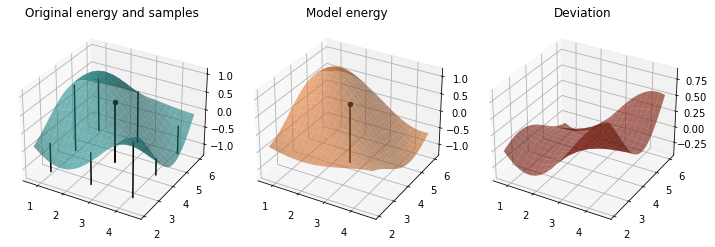

In [12]:
# Get some fresh random parameters and the model coefficients
parameters = np.random.random(2, requires_grad=True) * 2 * np.pi
coeffs = get_model_data(circuit, parameters)

# Define a mapped model that has the model coefficients fixed.
mapped_model = lambda params: model_cost(params, *coeffs)
plot_cost_and_model(circuit, mapped_model, parameters)

### Quantum Analytic Descent
Gehe wie folgt vor:  
1. Setze einen Referenzpunkt $\theta_0$.
2. Bestimme das klassische Modell um den Referenzpunkt.
3. Nutze Gradient descent um das Minimum des Modells zu finden.
4. Setze das bestimmte Minimum als neuen Referenzpunkt.
5. Wiederhole 2.-4. bis zur Konvergenz.

True energy at initial parameters: 0.5398

-Iteration 1-
Epoch   50: Model cost = -0.7981  at relative parameters [-0.2397  2.0158]
True energy at the minimum of the model: -0.7358296722728767
New reference parameters: [2.4222 6.0741]

-Iteration 2-
Epoch   50: Model cost = -1.0084  at relative parameters [0.6908 0.2794]
True energy at the minimum of the model: -0.9971225971605668
New reference parameters: [3.113  6.3535]

-Iteration 3-
Epoch   50: Model cost = -1.0  at relative parameters [ 0.0272 -0.0685]
True energy at the minimum of the model: -0.9999975843757788
New reference parameters: [3.1403 6.285 ]



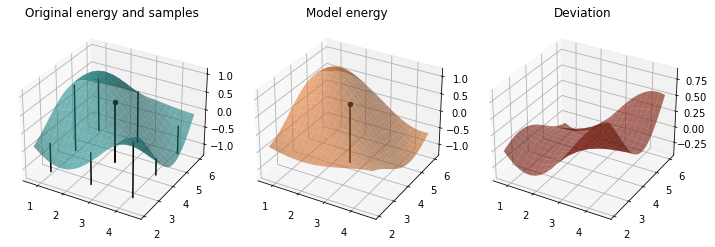

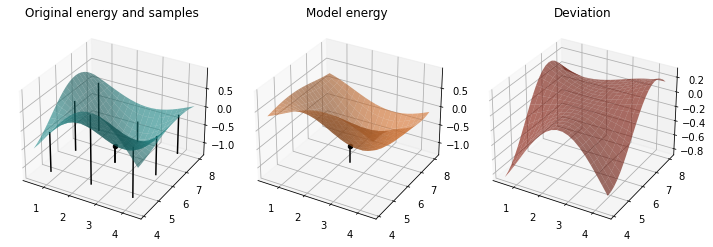

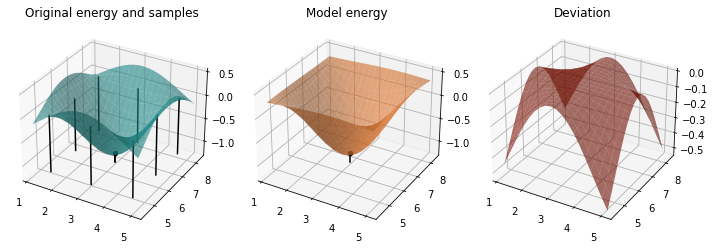

In [13]:
# Set the number of iterations of Steps 2, 3, and 4
N_iter_outer = 3
N_iter_inner = 50

past_coeffs = []
past_parameters = []
circuit_log = [circuit(parameters)]
model_logs = []

for iter_outer in range(N_iter_outer):
    # Model building phase of outer iteration - step 2.
    coeffs = get_model_data(circuit, parameters)
    past_coeffs.append(copy.deepcopy(coeffs))
    past_parameters.append(parameters.copy())
    # Map the model to be only depending on the parameters, not the coefficients.
    mapped_model = lambda params: model_cost(params, *coeffs)

    if iter_outer == 0:
        print(f"True energy at initial parameters: {np.round(coeffs[0], decimals=4)}\n")

    opt = qml.AdamOptimizer(0.05)
    # Recall that the parameters of the model are relative coordinates.
    # Correspondingly, we initialize at 0, not at parameters.
    relative_parameters = np.zeros_like(parameters, requires_grad=True)
    model_log = [mapped_model(relative_parameters)]
    print(f"-Iteration {iter_outer+1}-")

    # Run the optimizer for N_iter_inner epochs - Step 3.
    for iter_inner in range(N_iter_inner):
        relative_parameters = opt.step(mapped_model, relative_parameters)
        circuit_log.append(circuit(parameters + relative_parameters))
        model_log.append(mapped_model(relative_parameters))
        if (iter_inner + 1) % 50 == 0:
            E_model = mapped_model(relative_parameters)
            print(
                f"Epoch {iter_inner+1:4d}: Model cost = {np.round(E_model, 4)}",
                f" at relative parameters {np.round(relative_parameters, 4)}",
            )

    # Store the relative parameters that minimize the model by adding the shift - Step 4.
    parameters += relative_parameters
    E_original = circuit(parameters)
    print(f"True energy at the minimum of the model: {E_original}")
    print(f"New reference parameters: {np.round(parameters, 4)}\n")
    model_logs.append(model_log)
    

mapped_model = lambda params: model_cost(params, *past_coeffs[0])
plot_cost_and_model(circuit, mapped_model, past_parameters[0])

mapped_model = lambda params: model_cost(params, *past_coeffs[1])
plot_cost_and_model(circuit, mapped_model, past_parameters[1])

mapped_model = lambda params: model_cost(params, *past_coeffs[2])
plot_cost_and_model(circuit, mapped_model, past_parameters[2])

### Test mit anderer Funktion
#### Vorbereitung

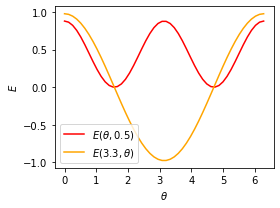

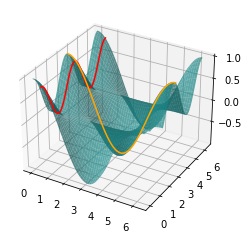

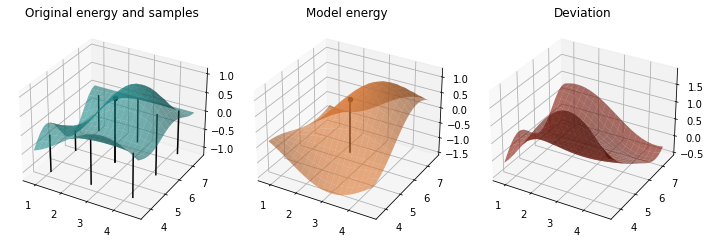

In [14]:
# Create a device with 2 qubits.
dev2 = qml.device("default.qubit", wires=2)

# Define the variational form V and observable M and combine them into a QNode.
@qml.qnode(dev, diff_method="parameter-shift", max_diff=2)
def circuit2(parameters):
    qml.RX(parameters[0], wires=0)
    qml.RY(parameters[0], wires=0)
    qml.RX(parameters[1], wires=1)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

# Create 1D sweeps through parameter space with the other parameter fixed.
num_samples = 50

# Fix a parameter position.
parameters = np.array([3.3, 0.5], requires_grad=True)

theta_func = np.linspace(0, 2 * np.pi, num_samples)
C1 = [circuit2(np.array([theta, parameters[1]])) for theta in theta_func]
C2 = [circuit2(np.array([parameters[0], theta])) for theta in theta_func]

# Show the sweeps.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(theta_func, C1, label="$E(\\theta, 0.5)$", color="r")
ax.plot(theta_func, C2, label="$E(3.3, \\theta)$", color="orange")
ax.set_xlabel("$\\theta$")
ax.set_ylabel("$E$")
ax.legend()
plt.tight_layout()

# Create a 2D grid and evaluate the energy on the grid points.
# We cut out a part of the landscape to increase clarity.
X, Y = np.meshgrid(theta_func, theta_func)
Z = np.zeros_like(X)
for i, t1 in enumerate(theta_func):
    for j, t2 in enumerate(theta_func):
        # Cut out the viewer-facing corner
        if (2 * np.pi - t2) ** 2 + t1 ** 2 > 4:
            Z[i, j] = circuit2([t1, t2])
        else:
            X[i, j] = Y[i, j] = Z[i, j] = np.nan

# Show the energy landscape on the grid.
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(4, 4))
surf = ax.plot_surface(X, Y, Z, label="$E(\\theta_1, \\theta_2)$", alpha=0.7, color="#209494")
line1 = ax.plot(
    [parameters[1]] * num_samples,
    theta_func,
    C1,
    label="$E(\\theta_1, \\theta_2^{(0)})$",
    color="r",
    zorder=100,
)
line2 = ax.plot(
    theta_func,
    [parameters[0]] * num_samples,
    C2,
    label="$E(\\theta_1^{(0)}, \\theta_2)$",
    color="orange",
    zorder=100,
)


# Get some fresh random parameters and the model coefficients
parameters = np.random.random(2, requires_grad=True) * 2 * np.pi
coeffs = get_model_data(circuit2, parameters)

# Define a mapped model that has the model coefficients fixed.
mapped_model = lambda params: model_cost(params, *coeffs)
plot_cost_and_model(circuit2, mapped_model, parameters)


#### Quantum Analytic Descent

True energy at initial parameters: 0.664

-Iteration 1-
Epoch   50: Model cost = -1.4005  at relative parameters [-2.3429 -0.4867]
True energy at the minimum of the model: 0.36113154303330797
New reference parameters: [0.4065 5.1165]

-Iteration 2-
Epoch   50: Model cost = -1.093  at relative parameters [-0.6159 -1.962 ]
True energy at the minimum of the model: -0.9780770657499521
New reference parameters: [-0.2094  3.1545]

-Iteration 3-
Epoch   50: Model cost = -1.0015  at relative parameters [ 0.2206 -0.0112]
True energy at the minimum of the model: -0.9999360909410991
New reference parameters: [0.0112 3.1432]



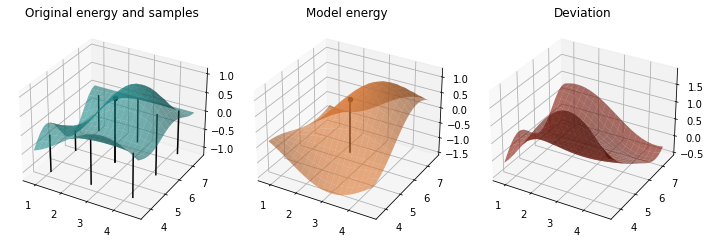

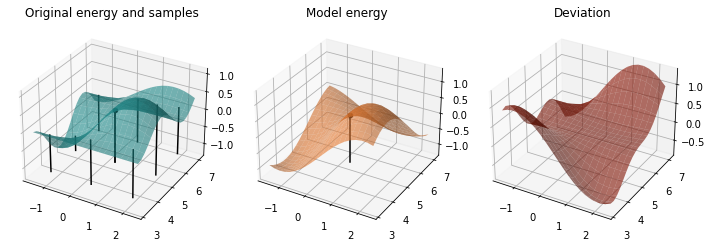

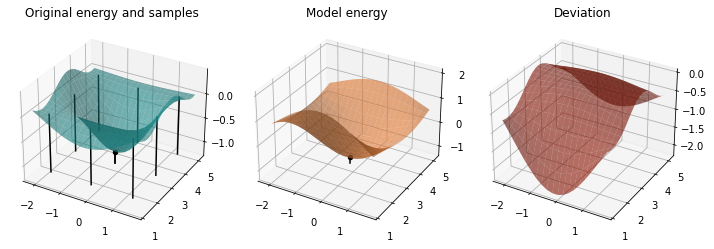

In [15]:
# Set the number of iterations of Steps 2, 3, and 4
N_iter_outer = 3
N_iter_inner = 50

past_coeffs = []
past_parameters = []
circuit_log = [circuit(parameters)]
model_logs = []

for iter_outer in range(N_iter_outer):
    # Model building phase of outer iteration - step 2.
    coeffs = get_model_data(circuit2, parameters)
    past_coeffs.append(copy.deepcopy(coeffs))
    past_parameters.append(parameters.copy())
    # Map the model to be only depending on the parameters, not the coefficients.
    mapped_model = lambda params: model_cost(params, *coeffs)

    if iter_outer == 0:
        print(f"True energy at initial parameters: {np.round(coeffs[0], decimals=4)}\n")

    opt = qml.AdamOptimizer(0.05)
    # Recall that the parameters of the model are relative coordinates.
    # Correspondingly, we initialize at 0, not at parameters.
    relative_parameters = np.zeros_like(parameters, requires_grad=True)
    model_log = [mapped_model(relative_parameters)]
    print(f"-Iteration {iter_outer+1}-")

    # Run the optimizer for N_iter_inner epochs - Step 3.
    for iter_inner in range(N_iter_inner):
        relative_parameters = opt.step(mapped_model, relative_parameters)
        circuit_log.append(circuit(parameters + relative_parameters))
        model_log.append(mapped_model(relative_parameters))
        if (iter_inner + 1) % 50 == 0:
            E_model = mapped_model(relative_parameters)
            print(
                f"Epoch {iter_inner+1:4d}: Model cost = {np.round(E_model, 4)}",
                f" at relative parameters {np.round(relative_parameters, 4)}",
            )

    # Store the relative parameters that minimize the model by adding the shift - Step 4.
    parameters += relative_parameters
    E_original = circuit(parameters)
    print(f"True energy at the minimum of the model: {E_original}")
    print(f"New reference parameters: {np.round(parameters, 4)}\n")
    model_logs.append(model_log)
    

mapped_model = lambda params: model_cost(params, *past_coeffs[0])
plot_cost_and_model(circuit2, mapped_model, past_parameters[0])

mapped_model = lambda params: model_cost(params, *past_coeffs[1])
plot_cost_and_model(circuit2, mapped_model, past_parameters[1])

mapped_model = lambda params: model_cost(params, *past_coeffs[2])
plot_cost_and_model(circuit2, mapped_model, past_parameters[2])

### Zusammenfassung
Es wurde ein Programm zur Durchführung von Quantum Analytic Descent geschrieben und dieses Anhand von zwei einfachen Beispielen getestet. Es konnte gezeigt werden, dass in diesen Beispielen QAD verwendet werden kann, um das Minimum der Kostenfunktion zu finden.

[Pennylane Tutorial](https://pennylane.ai/qml/demos/tutorial_quantum_analytic_descent.html)